In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

from matplotlib import pyplot as plt
import pytz
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler

import networkx as nx
from scipy.sparse import csr_matrix, lil_matrix

from time import time

from queue import PriorityQueue
from networkx import Graph, connected_components, gomory_hu_tree

#from datamodel import Data, PYJEDAIFeature
#from evaluation import Evaluation
#from utils import are_matching

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from tqdm import tqdm

from scipy.spatial.distance import pdist, squareform

from collections import defaultdict

import random

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')  # Adjust the path

#import datamodel
#import evaluation
#import utils
#from datamodel import Data, PYJEDAIFeature
#from evaluation import Evaluation
#from utils import are_matching

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/new_data_preprocessed.csv')

In [ ]:
dataset

,Start_datetime,End_datetime,Volume (kWh),Charge_Point_ID,max P per EVSE (kW),Dur_float,Charging_time,Idle_time
0,0.174974,0.460698,0.097789,0000002411,0.000000,0.533854,0.102978,0.533849
1,0.306722,0.048490,0.156462,0000002343,0.000000,0.618000,0.164765,0.617991
2,0.665729,0.156636,0.758690,0000002207,0.000000,0.466378,0.798951,0.466329
3,0.692941,0.037943,0.126233,0000002487,0.000000,0.212909,0.132932,0.212901
4,0.791127,0.000115,0.035747,0000002255,0.000000,0.042902,0.037644,0.042900
...,...,...,...,...,...,...,...,...
53128,0.678172,0.454358,0.016149,T54HU10321013,0.285714,0.020170,0.007482,0.020170
53129,0.716641,0.472716,0.359898,T124IT10521065,1.000000,0.016831,0.069483,0.016827
53130,0.731864,0.500696,0.045258,0000002193,0.000000,0.055027,0.047660,0.055024
53131,0.792080,0.505492,0.048345,T124IT10521065,1.000000,0.004150,0.009334,0.004150


In [ ]:
dataset = dataset.drop(["Charge_Point_ID"], axis = 1)

In [ ]:
dataset

,Start_datetime,End_datetime,Volume (kWh),max P per EVSE (kW),Dur_float,Charging_time,Idle_time
0,0.174974,0.460698,0.097789,0.000000,0.533854,0.102978,0.533849
1,0.306722,0.048490,0.156462,0.000000,0.618000,0.164765,0.617991
2,0.665729,0.156636,0.758690,0.000000,0.466378,0.798951,0.466329
3,0.692941,0.037943,0.126233,0.000000,0.212909,0.132932,0.212901
4,0.791127,0.000115,0.035747,0.000000,0.042902,0.037644,0.042900
...,...,...,...,...,...,...,...
53128,0.678172,0.454358,0.016149,0.285714,0.020170,0.007482,0.020170
53129,0.716641,0.472716,0.359898,1.000000,0.016831,0.069483,0.016827
53130,0.731864,0.500696,0.045258,0.000000,0.055027,0.047660,0.055024
53131,0.792080,0.505492,0.048345,1.000000,0.004150,0.009334,0.004150


In [ ]:
df_test = dataset #[:20000]

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)


class EquivalenceCluster(PYJEDAIFeature):

    def __init__(self, data : Data) -> None:
        super().__init__()
        self.data : Data = data
        self.d1_entities = OrderedSet()
        self.d2_entities = OrderedSet()

    def __init__(self, data : Data, flattened_cluster : list) -> None:
        super().__init__()
        self.data : Data = data
        self.d1_entities = set()
        self.d2_entities = set()
        self.add_entities(flattened_cluster)

    def get_entity_dataset(self, entity : int) -> set:
        return self.d1_entities \
                if(entity < self.data.dataset_limit) \
                else self.d2_entities

    def add_entity(self, entity : int) -> None:
        target_dataset_entities = self.get_entity_dataset(entity)
        target_dataset_entities.add(entity)

    def add_entities(self, entities : list) -> None:
        for entity in entities:
            self.add_entity(entity)

    def get_entities(self) -> list:
        return list((self.get_D1_entities() | self.get_D2_entities()))

    def get_D1_entities(self) -> set:
        return self.d1_entities

    def get_D2_entities(self) -> set:
        return self.d2_entities

    def has_entities(self) -> bool:
        return self.has_D1_entities() or self.has_D2_entities()

    def has_D1_entities(self) -> bool:
        return (len(self.d1_entities) > 0)

    def has_D2_entities(self) -> bool:
        return (len(self.d1_entities) > 0)

    def has_entity(self, entity : int) -> bool:
        target_dataset_entities = self.get_entity_dataset(entity)
        return (entity in target_dataset_entities)

    def remove_entity(self, entity: int) -> None:
        target_dataset_entities = self.get_entity_dataset(entity)
        target_dataset_entities.remove(entity)

    def remove_entities(self, entities: list) -> None:
        for entity in entities:
            self.remove_entity(entity)

    def flatten(self) -> list:
        flattened_cluster : list = []

        for d1_entity in self.d1_entities:
            flattened_cluster.append(d1_entity)
        for d2_entity in self.d2_entities:
            flattened_cluster.append(d2_entity)

        return flattened_cluster

    def evaluate(self,
                 prediction=None,
                 export_to_df: bool = False,
                 export_to_dict: bool = False,
                 with_classification_report: bool = False,
                 verbose: bool = True) -> any:
        pass

    def _configuration(self) -> dict:
        pass

    def stats(self) -> None:
        pass

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)


class Vertex(PYJEDAIFeature):
    def __init__(self,
                 identifier : int,
                 edges : list = None) -> None:
        super().__init__()
        self.set_identifier(identifier=identifier)
        self.set_attached_edges(attached_edges=0)
        self.set_weight_sum(weight_sum=0)
        self.set_edges(edges={})
        if(edges is not None): self.insert_edges(edges=edges)

    def set_identifier(self, identifier : int) -> None:
        self.identifier : int = identifier

    def set_attached_edges(self, attached_edges : int) -> None:
        self.attached_edges : int = attached_edges

    def set_weight_sum(self, weight_sum : float) -> None:
        self.weight_sum : float = weight_sum

    def set_edges(self, edges : dict) -> None:
        self.edges : dict = edges

    def set_average_weight(self, average_weight : float) -> None:
        self.average_weight : float = average_weight

    def insert_edges(self, edges : list) -> None:
        for edge in edges:
            self.insert_edge(edge=edge)

    def insert_edge(self, edge : tuple) -> None:
        vertex, weight = edge
        self.update_weight_sum_by(update_value=weight)
        self.update_attached_edges_by(update_value=1)
        self.edges[vertex] = weight
        self.update_average_weight()

    def remove_edges(self, edges : list) -> None:
        for edge in edges:
            self.remove_edge(edge=edge)

    def remove_edge(self, edge : int) -> None:
        weight = self.edges.pop(edge, None)
        if(weight is not None):
            self.update_attached_edges_by(update_value=-1)
            self.update_weight_sum_by(update_value=-weight)
            self.update_average_weight()

    def get_attached_edges(self) -> int:
        return self.attached_edges

    def get_weight_sum(self) -> float:
        return self.weight_sum

    def get_edges(self) -> list:
        return self.edges

    def get_identifier(self) -> int:
        return self.identifier

    def get_similarity_with(self, entity : int) -> float:
        return self.edges[entity] if entity in self.edges else 0.0

    def update_weight_sum_by(self, update_value : float) -> None:
        self.set_weight_sum(self.get_weight_sum() + update_value)

    def update_attached_edges_by(self, update_value : float) -> None:
        self.set_attached_edges(self.get_attached_edges() + update_value)

    def update_average_weight(self, negative = True) -> None:
        _average_weight : float = (self.get_weight_sum() / self.get_attached_edges())
        _average_weight = -_average_weight if negative else _average_weight
        self.set_average_weight(average_weight=_average_weight)

    def has_edges(self):
        return (self.get_attached_edges() > 0)

    def __lt__(self, other):
        return self.average_weight < other.average_weight

    def __le__(self, other):
        return self.average_weight <= other.average_weight

    def __eq__(self, other):
        return self.average_weight == other.average_weight

    def __ne__(self, other):
        return self.average_weight != other.average_weight

    def __gt__(self, other):
        return self.average_weight > other.average_weight

    def __ge__(self, other):
        return self.average_weight >= other.average_weight

    def evaluate(self,
                 prediction=None,
                 export_to_df: bool = False,
                 export_to_dict: bool = False,
                 with_classification_report: bool = False,
                 verbose: bool = True) -> any:
        pass

    def _configuration(self) -> dict:
        pass

    def stats(self) -> None:
        pass

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)


class AbstractClustering(PYJEDAIFeature):

    def __init__(self) -> None:
        super().__init__()
        self.data: Data
        self.similarity_threshold: float = 0.1

    def evaluate(self,
                 prediction,
                 export_to_df: bool = False,
                 export_to_dict: bool = False,
                 with_classification_report: bool = False,
                 verbose: bool = True) -> any:

        if prediction is None:
            if self.blocks is None:
                raise AttributeError("Can not proceed to evaluation without build_blocks.")
            else:
                eval_blocks = self.blocks
        else:
            eval_blocks = prediction

        if self.data is None:
            raise AttributeError("Can not proceed to evaluation without data object.")

        if self.data.ground_truth is None:
            raise AttributeError("Can not proceed to evaluation without a ground-truth file. " +
                    "Data object has not been initialized with the ground-truth file")

        eval_obj = Evaluation(self.data)
        true_positives = 0
        entity_index = eval_obj._create_entity_index_from_clusters(eval_blocks)
        for _, (id1, id2) in self.data.ground_truth.iterrows():
            id1 = self.data._ids_mapping_1[id1]
            id2 = self.data._ids_mapping_1[id2] if self.data.is_dirty_er else self.data._ids_mapping_2[id2]
            if id1 in entity_index and    \
                id2 in entity_index and are_matching(entity_index, id1, id2):
                true_positives += 1
        # print(entity_index)
        eval_obj.calculate_scores(true_positives=true_positives)
        return eval_obj.report(self.method_configuration(),
                                export_to_df,
                                export_to_dict,
                                with_classification_report,
                                verbose)

    def stats(self) -> None:
        pass

    def export_to_df(self, prediction: list) -> pd.DataFrame:
        """creates a dataframe for the evaluation report

        Args:
            prediction (any): Predicted clusters

        Returns:
            pd.DataFrame: Dataframe containg evaluation scores and stats
        """
        pairs_df = pd.DataFrame(columns=['id1', 'id2'])
        for cluster in prediction:
            lcluster = list(cluster)
            for i1 in range(0, len(lcluster)):
                for i2 in range(i1+1, len(lcluster)):
                    if lcluster[i1] < self.data.dataset_limit:
                        id1 = self.data._gt_to_ids_reversed_1[lcluster[i1]]
                        id2 = self.data._gt_to_ids_reversed_1[lcluster[i2]] if self.data.is_dirty_er else self.data._gt_to_ids_reversed_2[lcluster[i2]]
                    else:
                        id2 = self.data._gt_to_ids_reversed_2[lcluster[i1]]
                        id1 = self.data._gt_to_ids_reversed_1[lcluster[i2]]
                    pairs_df = pd.concat(
                        [pairs_df, pd.DataFrame([{'id1':id1, 'id2':id2}], index=[0])],
                        ignore_index=True
                    )
        return pairs_df

    def sorted_indicators(self, first_indicator : int, second_indicator : int):
        return (first_indicator, second_indicator) if (first_indicator < second_indicator) else (second_indicator, first_indicator)

    def id_to_index(self, identifier : int):
        return identifier \
            if identifier < self.data.dataset_limit \
            else (identifier - self.data.dataset_limit)

    def index_to_id(self, index : int, left_dataset : True):
        return index if left_dataset else index + self.data.dataset_limit

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)
#print(np.random.rand(4))

class MergeCenterClustering(AbstractClustering): #AbstractClustering
    """Implements the Merge Center Clustering algorithm. It is a simplified version of the Center Clustering algorithm,
       where the pair entities are not chosen as cluster center and member respectively based on their cumulative, normalized
       weight in the original graph. Rather, entities of the left dataset are set as centers and their right dataset candidates
       are set as member of the corresponding clusters.
    """


    _method_name: str = "Merge Center Clustering"
    _method_short_name: str = "MCC"
    _method_info: str = "Ιmplements the Merge Center Clustering algorithm," + \
        "In essence, it implements Center Clustering without the cumulative, " + \
        "normalized weight calculation. Left dataset entities are set as candidate cluster centers."
    def __init__(self) -> None:
        super().__init__()
        self.similarity_threshold: float
#test similarity threshold 0-1 me vima 0.05
    def process(self, graph: Graph, data: Data, similarity_threshold: float = 0.95) -> list:

        start_time = time()
        self.similarity_threshold : float = similarity_threshold
        self.data = data
        comparisons = PriorityQueue(maxsize = graph.number_of_edges()*2)
        #print(self.similarity_threshold)
        for (v1, v2, data) in graph.edges(data=True):
            similarity_score = data.get('weight', 0)
            #print(similarity_score)
            if similarity_score > similarity_threshold: #self.threshold:
                comparisons.put((-similarity_score, v1, v2))

        new_graph = nx.Graph()
        cluster_centers = set()
        cluster_members = set()

        while not comparisons.empty():
            similarity_score, v1, v2 = comparisons.get()
            v1_is_center : bool = v1 in cluster_centers
            v2_is_center : bool = v2 in cluster_centers
            v1_is_member : bool = v1 in cluster_members
            v2_is_member : bool = v2 in cluster_members

            if(not(v1_is_center or v2_is_center or v1_is_member or v2_is_member)):
                cluster_centers.add(v1)
                cluster_members.add(v2)
                new_graph.add_edge(v1, v2, weight=-similarity_score)
            elif ((v1_is_center and v2_is_center) or (v1_is_member and v2_is_member)):
                continue
            elif (v1_is_center):
                cluster_members.add(v2)
                new_graph.add_edge(v1, v2, weight=-similarity_score)
            elif (v2_is_center):
                cluster_members.add(v1)
                new_graph.add_edge(v1, v2, weight=-similarity_score)

        clusters = list(connected_components(new_graph))
        self.execution_time = time() - start_time
        return clusters

    def _configuration(self) -> dict:
        return {}

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)

class RicochetSRClustering(AbstractClustering):
    """Implements the Ricochet SR Clustering algorithm. Implements the so-called "New Algorithm"
       by Zoltan Kiraly 2013, which is a 3/2-approximation to the Maximum Stable Marriage (MSM) problem.
       The pairs resulting from the approximation of the stable relationships are translated into a graph,
       whose connected components we retain.
    """

    _method_name: str = "Ricochet SR Clustering"
    _method_short_name: str = "RSRC"
    _method_info: str = "Ιmplements the Ricochet SR Clustering algorithm," + \
        "In essence, it is a 3/2-approximation to the Maximum Stable Marriage (MSM) problem."
    def __init__(self) -> None:
        super().__init__()
        self.similarity_threshold : float

    def process(self,
                graph: Graph,
                data: Data,
                similarity_threshold: float = 0.5) -> list:

        start_time = time()
        self.similarity_threshold : float = similarity_threshold
        self.data = data
        clusters : list = []
        self.vertices : dict = {}
        self.sorted_vertices = PriorityQueue(maxsize = self.data.num_of_entities)

        for (v1, v2, data) in graph.edges(data=True):
            d1_id, d2_id = self.sorted_indicators(v1, v2)
            similarity = data.get('weight', 0)
            if similarity > self.similarity_threshold:
                if d1_id not in self.vertices: self.vertices[d1_id] = Vertex(identifier=d1_id)
                if d2_id not in self.vertices: self.vertices[d2_id] = Vertex(identifier=d2_id)
                self.vertices[d1_id].insert_edge(edge=(d2_id, similarity))
                self.vertices[d2_id].insert_edge(edge=(d1_id, similarity))

        for _, vertex in self.vertices.items():
            if(vertex.has_edges()):
                self.sorted_vertices.put(vertex)

        if(self.sorted_vertices.empty()):
            return clusters

        self.centers : set = set()
        self.members : set = set()
        self.center_of : dict = {}
        self.similarity_with_center : dict = defaultdict(float)
        self.current_clusters : dict = defaultdict(set)

        top_vertex : Vertex = self.sorted_vertices.get()
        vertex_id : int = top_vertex.get_identifier()
        self.centers.add(vertex_id)
        self.center_of[vertex_id] = vertex_id
        self.current_clusters[vertex_id].add(vertex_id)
        self.similarity_with_center[vertex_id] = 1.0

        top_vertex_neighbor = list(top_vertex.edges.keys())[0]
        self.members.add(top_vertex_neighbor)
        self.center_of[top_vertex_neighbor] = vertex_id
        self.current_clusters[vertex_id].add(top_vertex_neighbor)
        self.similarity_with_center[top_vertex_neighbor] = top_vertex.get_similarity_with(top_vertex_neighbor)

        while(not self.sorted_vertices.empty()):
            vertex = self.sorted_vertices.get()
            vertex_id = vertex.get_identifier()
            to_reassign : set = set()
            centers_to_reassign : set = set()

            for neighbor, similarity in vertex.edges.items():
                if(neighbor in self.centers):
                    continue
                previous_similarity = self.similarity_with_center[neighbor]
                if(previous_similarity >= similarity):
                    continue
                to_reassign.add(neighbor)
                break

            if(to_reassign):
                if(vertex_id in self.members):
                    self.members.remove(vertex_id)
                    previous_center = self.center_of[vertex_id]
                    self.current_clusters[previous_center].remove(vertex_id)
                    if(len(self.current_clusters[previous_center]) < 2):
                        centers_to_reassign.add(previous_center)
                to_reassign.add(vertex_id)
                for assignee in to_reassign:
                    self.current_clusters[vertex_id].add(assignee)
                self.centers.add(vertex_id)

            for reassign in to_reassign:
                if(reassign != vertex_id):
                    if(reassign in self.members):
                        reassign_previous_center = self.center_of[reassign]
                        self.current_clusters[reassign_previous_center].remove(reassign)

                        if(len(self.current_clusters[reassign_previous_center]) < 2):
                            centers_to_reassign.add(reassign_previous_center)
                    self.members.add(reassign)
                    self.center_of[reassign] = vertex_id
                    self.similarity_with_center[reassign] = vertex.get_similarity_with(reassign)

            for center_to_reassign in centers_to_reassign:
                if(len(self.current_clusters[center_to_reassign]) > 1):
                    continue
                self.centers.remove(center_to_reassign)
                _ = self.current_clusters.pop(center_to_reassign, None)

                max_similarity : float = 0.0
                new_center : int = vertex_id

                for center in self.centers:
                    new_similarity : float = self.vertices[center].get_similarity_with(center_to_reassign)
                    if(new_similarity > 0.0):
                        if(len(self.current_clusters[center]) > 1):
                            continue
                        if(new_similarity > max_similarity):
                            max_similarity = new_similarity
                            new_center = center
                if(len(self.current_clusters[new_center]) > 1):
                    continue
                self.current_clusters[new_center].add(center_to_reassign)
                self.members.add(center_to_reassign)
                self.center_of[center_to_reassign]= new_center
                self.similarity_with_center[center_to_reassign] = max_similarity

        for entity in range(self.data.num_of_entities):
            if(entity not in self.members and entity not in self.centers):
                self.centers.add(entity)
                self.center_of[entity] = entity
                self.current_clusters[entity].add(entity)
                self.similarity_with_center[entity] = 1.0

        clusters = []
        for center, members in self.current_clusters.items():
            center_equivalence_cluster = EquivalenceCluster(data=self.data,
                                                            flattened_cluster=list(members))
            clusters.append(set(center_equivalence_cluster.flatten()))

        self.execution_time = time() - start_time
        return clusters

    def _configuration(self) -> dict:
        return {}

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)

class CenterClustering(AbstractClustering):
    """Implements the Center Clustering algorithm. Input comparisons (graph edges) are sorted in descending order of similarity.
       Pairs of entities connected by these edges form the basis of the updated graph. Entities are evaluated to determine if they will serve
       as a center of a future cluster or as its member. This evaluation is based on a comparison of their cumulative edge weights in the graph,
       normalized by the number of edges in which they are involved. Finally, the algorithm identifies connected components within the graph,
       using the previously defined centers as the focal points for forming clusters.
    """


    _method_name: str = "Center Clustering"
    _method_short_name: str = "CC"
    _method_info: str = "Ιmplements the Center Clustering algorithm," + \
        "In essence, it keeps it defines if a node within an edge constitutes a center or member of future clusters" + \
        " by normalized over the graph weight sum comparison"
    def __init__(self) -> None:
        super().__init__()
        self.similarity_threshold: float

    def process(self, graph: Graph, data: Data, similarity_threshold: float = 0.5) -> list:

        start_time = time()
        self.similarity_threshold : float = similarity_threshold
        self.data = data
        edges_weight = defaultdict(float)
        edges_attached = defaultdict(int)
        comparisons = PriorityQueue(maxsize = graph.number_of_edges()*2)

        for (v1, v2, data) in graph.edges(data=True):
            similarity_score = data.get('weight', 0)
            if similarity_score > self.similarity_threshold:
                comparisons.put((-similarity_score, v1, v2))
                edges_weight[v1] = edges_weight[v1] + similarity_score
                edges_weight[v2] = edges_weight[v2] + similarity_score

                edges_attached[v1] = edges_attached[v1] + 1
                edges_attached[v2] = edges_attached[v2] + 1

        new_graph = Graph()
        cluster_centers = set()
        cluster_members = set()

        while not comparisons.empty():
            similarity_score, v1, v2 = comparisons.get()
            v1_is_center : bool = v1 in cluster_centers
            v2_is_center : bool = v2 in cluster_centers
            v1_is_member : bool = v1 in cluster_members
            v2_is_member : bool = v2 in cluster_members

            if(not(v1_is_center or v2_is_center or v1_is_member or v2_is_member)):
                w1 = edges_weight[v1] / edges_attached[v1]
                w2 = edges_weight[v2] / edges_attached[v2]

                cluster_centers.add(v1 if w1 > w2 else v2)
                cluster_members.add(v1 if w1 <= w2 else v2)
                new_graph.add_edge(v1, v2, weight=-similarity_score)
            elif ((v1_is_center and v2_is_center) or (v1_is_member and v2_is_member)):
                continue
            elif (v1_is_center and not v2_is_member):
                cluster_members.add(v2)
                new_graph.add_edge(v1, v2, weight=-similarity_score)
            elif (v2_is_center and not v1_is_member):
                cluster_members.add(v1)
                new_graph.add_edge(v1, v2, weight=-similarity_score)

        clusters = list(connected_components(new_graph))
        self.execution_time = time() - start_time
        return clusters

    def _configuration(self) -> dict:
        return {}

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)

class ConnectedComponentsClustering(AbstractClustering):
    """Creates the connected components of the graph. \
        Applied to graph created from entity matching. \
        Input graph consists of the entity ids (nodes) and the similarity scores (edges).
    """

    _method_name: str = "Connected Components Clustering"
    _method_short_name: str = "CCC"
    _method_info: str = "Gets equivalence clusters from the " + \
                    "transitive closure of the similarity graph."

    def __init__(self) -> None:
        super().__init__()
        self.similarity_threshold: float

    def process(self, graph: Graph, data: Data, similarity_threshold: float = None) -> list:
        """NetworkX Connected Components Algorithm in the produced graph.

        Args:
            graph (Graph): Consists of the entity ids (nodes) and the similarity scores (edges).

        Returns:
            list: list of clusters
        """
        start_time = time()
        self.data = data
        self.similarity_threshold: float = similarity_threshold
        graph_copy = graph.copy()
        if self.similarity_threshold is not None:
            for x in graph.edges(data=True):
                if x[2]['weight'] < self.similarity_threshold:
                    graph_copy.remove_edge(x[0], x[1])
        clusters = list(connected_components(graph_copy))
        # print(clusters)
        # print("Number of clusters: ", len(clusters))
        resulting_clusters = list(filter(lambda x: len(x) == 2, clusters)) \
                                if not data.is_dirty_er else clusters
        # print("Number of clusters after filtering: ", len(resulting_clusters))
        self.execution_time = time() - start_time
        return resulting_clusters

    def _configuration(self) -> dict:
        return {}

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)

class MarkovClustering(AbstractClustering):
    """Implements the Markov Clustering algorithm. It simulates random walks on a (n x n) matrix as the adjacency matrix
       of a weighted, similarity graph. It alternates an expansion step and an inflation step until an equilibrium state is reached.
       Entries with similarity above threhold, are inserted into final graph, whose CCs we retain.
    """

    _method_name: str = "Markov Clustering"
    _method_short_name: str = "MCL"
    _method_info: str = "Ιmplements the Markov Clustering algorithm," + \
        "In essence, it simulates random walks on a (n x n) matrix as the adjacency " + \
        "matrix of a graph. It alternates an expansion step and an inflation step " + \
        "until an equilibrium state is reached. We retain the connected components " + \
        "of the graph resulting from final similarity matrix entries valued over threshold."
    def __init__(self) -> None:
        super().__init__()
        self.similarity_threshold : float
        self.cluster_threshold : float
        self.matrix_similarity_threshold : float
        self.similarity_checks_limit : int

    def process(self, graph: Graph,
                data: Data,
                similarity_threshold: float = 0.5,
                cluster_threshold: float = 0.001,
                matrix_similarity_threshold: float = 0.00001,
                similarity_checks_limit : int = 10) -> list:

        start_time = time()
        self.similarity_threshold : float = similarity_threshold
        self.cluster_threshold : float = cluster_threshold
        self.matrix_similarity_threshold : float = matrix_similarity_threshold
        self.similarity_checks_limit : int = similarity_checks_limit
        self.data = data
        self.current_similarity = lil_matrix((self.data.num_of_entities, data.num_of_entities), dtype=float)
        new_graph : Graph = Graph()


        for (v1, v2, data) in graph.edges(data=True):
            d1_id, d2_id = self.sorted_indicators(v1, v2)
            similarity_score = data.get('weight', 0)

            if(similarity_score > self.similarity_threshold):
                self.current_similarity[d1_id, d2_id] = similarity_score
                self.current_similarity[d2_id, d1_id] = similarity_score

        self.set_node_loop(similarity = 1.0)
        self.normalize()

        for check in range(self.similarity_checks_limit):
            self.previous_similarity = self.current_similarity.copy()
            self.inflate()
            self.normalize()
            self.expand()
            self.normalize()
            print(check+1)
            if(self.equilibrium()):
                break

        edges_populated = self.get_existing_indices(matrix=self.current_similarity)
        for edge in edges_populated:
            row, column = edge
            new_similarity = self.current_similarity[row, column]
            final_row, final_column = self.sorted_indicators(row, column)

            if(new_graph.has_edge(final_row, final_column)):
                existing_similarity = new_graph[final_row][final_column]["weight"]
                if(new_similarity > existing_similarity):
                    new_graph[final_row][final_column]["weight"] = new_similarity
            elif(new_similarity > self.cluster_threshold):
                new_graph.add_edge(final_row, final_column, weight=new_similarity)

        clusters = list(connected_components(new_graph))
        self.execution_time = time() - start_time
        return clusters

    def set_node_loop(self, similarity : float = 1.0) -> None:
        rows : int = self.current_similarity.shape[0]
        print(rows)
        for row in range(rows):
            self.current_similarity[row, row] = similarity

    def normalize(self) -> None:
        column_sums = self.current_similarity.sum(axis=0)
        column_sums[column_sums == 0] = 1
        self.current_similarity = self.current_similarity.multiply(1. / column_sums)

    def expand(self) -> None:
        self.current_similarity = self.current_similarity.power(2)

    def inflate(self) -> None:
        self.current_similarity = self.current_similarity.dot(self.current_similarity)

    def equilibrium(self) -> None:
        self.current_similarity = self.current_similarity.tocsr()
        self.previous_similarity = self.previous_similarity.tocsr()

        current_indices = self.get_existing_indices(matrix=self.current_similarity)
        previous_indices = self.get_existing_indices(matrix=self.previous_similarity)
        shared_indices = current_indices & previous_indices

        for indices in shared_indices:
            row, column = indices
            if(abs(self.current_similarity[row, column] - self.previous_similarity[row, column]) > self.matrix_similarity_threshold):
                return False

        return True

    def get_existing_indices(self, matrix):
        return set([indices for indices in zip(*matrix.nonzero())])

    def _configuration(self) -> dict:
        return {}

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)

class CutClustering(AbstractClustering):
    """Implements the Cut Clustering algorithm. Retains the candidate pairs whose similarity is over the specified threshold.
       Those pairs are mapped into graph edges. Using the newly defined graph, we retrieve its Gomory Hu Tree representation
       using the Edmonds Karp flow function, while edges' capacity is considered to be infinite. We return the connected components
       of the resulting minimum s-t cuts for the pairs in the original, trimmed graph.
    """

    _method_name: str = "Cut Clustering"
    _method_short_name: str = "CTC"
    _method_info: str = "Ιmplements the Cut Clustering algorithm," + \
        "In essence, it calculates the Gomory Hu Tree of the graph resulting from input similarity pairs. " + \
        "We retain the connected components of this tree."
    def __init__(self) -> None:
        super().__init__()
        self.similarity_threshold: float

    def process(self, graph: Graph, data: Data, similarity_threshold: float = 0.5, alpha: float = 0.2) -> list:

        start_time = time()
        self.similarity_threshold : float = similarity_threshold
        self.data = data
        threshold_trimmed_graph : Graph = Graph()

        for (v1, v2, data) in graph.edges(data=True):
            similarity_score = data.get('weight', 0)
            d1_id, d2_id = self.sorted_indicators(v1, v2)
            if similarity_score > self.similarity_threshold:
                threshold_trimmed_graph.add_edge(d1_id, d2_id, weight=similarity_score)

        sink_node : int = self.data.num_of_entities
        threshold_trimmed_graph.add_node(sink_node)
        for node in graph.nodes():
            if node != sink_node:
                threshold_trimmed_graph.add_edge(sink_node, node, weight=alpha)

        final_gomory_hu_tree = gomory_hu_tree(G=threshold_trimmed_graph, capacity='weight')
        final_gomory_hu_tree.remove_node(sink_node)
        clusters = list(connected_components(final_gomory_hu_tree))

        print(len(clusters))
        self.execution_time = time() - start_time
        return clusters

    def _configuration(self) -> dict:
        return {}

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)

class CorrelationClustering(AbstractClustering):
    """Implements the Correlation Clustering algorithm. Candidate pairs are mapped into a graph, whose connected components
       act as our initial clusters. We iteratively choose one of the 3 possible moves (change, merge, break up cluster) and
       we apply them on randomly chosen entities. We decide whether we should conduct the move or not, based on an objective function,
       which quantifies the quality of our clusters (contain similar entities, seperate disimilar ones)
    """


    _method_name: str = "Correlation Clustering"
    _method_short_name: str = "CC"
    _method_info: str = "Ιmplements the Correlation Clustering algorithm," + \
        "In essence, it implements iterative clustering, " + \
        "reassigning clusters to randomly chosen entities based on the reassignment's effect on our objective function " + \
        "that evaluates the quality of the newly defined clusters."
    def __init__(self) -> None:
        super().__init__()
        self.similarity_threshold: float
        self.initial_threshold : float
        self.similarity_threshold : float
        self.non_similarity_threshold : float
        self.move_limit : int
        self.lsi_iterations: int
    def process(self,
                graph: Graph,
                data: Data,
                initial_threshold: float = 0.5,
                similarity_threshold: float = 0.8,
                non_similarity_threshold: float = 0.2,
                move_limit: int = 3,
                lsi_iterations: int = 100) -> list:

        start_time = time()
        self.data : Data = data
        self.initial_threshold : float = initial_threshold
        self.similarity_threshold : float = similarity_threshold
        self.non_similarity_threshold : float = non_similarity_threshold
        self.move_limit : int = move_limit
        self.lsi_iterations: int = lsi_iterations

        self.num_of_source_entities = self.data.num_of_entities_1
        self.num_of_target_entities = self.data.num_of_entities_1 if self.data.is_dirty_er \
                                      else self.data.num_of_entities_2

        self.similarity = lil_matrix((self.num_of_source_entities, self.num_of_target_entities), dtype=float)
        new_graph = graph.copy()

        for (v1, v2, data) in graph.edges(data=True):
            d1_id, d2_id = self.sorted_indicators(v1, v2)
            d1_index, d2_index = (self.id_to_index(d1_id), self.id_to_index(d2_id))
            similarity_score = data['weight']
            self.similarity[d1_index, d2_index] = similarity_score
            if similarity_score < self.initial_threshold:
                new_graph.remove_edge(v1, v2)

        initial_clusters = [list(connected_component) for connected_component in connected_components(new_graph)]

        self.clusters = [EquivalenceCluster(data=self.data, flattened_cluster=cluster) for cluster in initial_clusters]
        self.initial_clusters_num = len(initial_clusters)
        self.max_clusters_num = self.initial_clusters_num + 10
        self.entity_cluster_index = [0] * self.data.num_of_entities
        self.valid_entities = set()

        for cluster_index, cluster in enumerate(self.clusters):
            for entity in range(self.data.num_of_entities):
                if(cluster.has_entity(entity=entity)):
                    self.valid_entities.add(entity)
                    self.entity_cluster_index[entity] = cluster_index
        self.valid_entities = list(self.valid_entities)

        self.similar = lil_matrix((self.num_of_source_entities, self.num_of_target_entities), dtype=bool)
        self.not_similar = lil_matrix((self.num_of_source_entities, self.num_of_target_entities), dtype=bool)

        for d1_index in range(self.num_of_source_entities):
            for d2_index in range(d1_index, self.num_of_target_entities):
                self.not_similar[d1_index, d2_index] = self.similarity[d1_index, d2_index] < self.non_similarity_threshold
                self.similar[d1_index, d2_index] = self.similarity[d1_index, d2_index] > self.similarity_threshold

        random.seed(RANDOM_SEED)
        previous_OF : int = self.calculate_OF()

        for iteration in range(self.lsi_iterations):
            move_index : int = self.choose_move()
            current_OF : int = self.move(move_index, previous_OF)
            previous_OF = current_OF

        final_clusters : list = []
        for cluster in self.clusters:
            if(cluster.has_entities()):
                final_clusters.append(set(cluster.flatten()))
        self.execution_time = time() - start_time
        return final_clusters

    def calculate_OF(self) -> int:
        OF : int = 0

        for d1_index in range(self.num_of_source_entities):
            for d2_index in range(d1_index, self.num_of_target_entities):
                d1_entity = self.index_to_id(index=d1_index, left_dataset=True)
                d2_entity = self.index_to_id(index=d2_index, left_dataset=self.data.is_dirty_er)

                similar_and_cluster_match = self.similar[d1_index, d2_index] and \
                (self.entity_cluster_index[d1_entity] == self.entity_cluster_index[d2_entity])
                dissimilar_and_cluster_missmatch = self.not_similar[d1_index, d2_index] and \
                (self.entity_cluster_index[d1_entity] != self.entity_cluster_index[d2_entity])

                if(similar_and_cluster_match or dissimilar_and_cluster_missmatch):
                    OF += 1

        return OF

    def choose_move(self) -> int:
        move = random.randint(0, self.move_limit - 1)
        while(move == 1 and len(self.clusters) == 1):
            move = random.randint(0, self.move_limit - 1)
        return move

    def move(self, move_index : int, previous_OF : int):
        print(f"Move[{move_index}] OF[{previous_OF}]")
        if(move_index == 0):
            random_entity = random.choice(self.valid_entities)
            random_cluster = random.randint(0, self.initial_clusters_num - 1)
            while(not self.clusters[random_cluster].has_entities()):
                random_cluster = random.randint(0, self.initial_clusters_num - 1)
            return self.change_entity_cluster(previous_OF, random_entity, random_cluster)
        elif(move_index == 1):
            previous_cluster = random.randint(0, self.initial_clusters_num - 1)
            while(not self.clusters[previous_cluster].has_entities()):
                previous_cluster = random.randint(0, self.initial_clusters_num - 1)

            new_cluster = random.randint(0, self.initial_clusters_num - 1)
            while((previous_cluster == new_cluster) or (not self.clusters[new_cluster].has_entities())):
                new_cluster = random.randint(0, self.initial_clusters_num - 1)

            return self.unify_clusters(previous_OF, previous_cluster, new_cluster)

        elif(move_index == 2):
            previous_cluster = random.randint(0, self.initial_clusters_num - 1)
            while(not self.clusters[previous_cluster].has_entities()):
                previous_cluster = random.randint(0, self.initial_clusters_num - 1)
            return self.seperate_clusters(previous_OF, previous_cluster)
        else:
            raise ValueError(f"Invalid Move Index \"{move_index}\": Choose 0->2")
            return float("inf")


    def change_entity_cluster(self, previous_OF : int, entity : int, new_cluster : int):
        previous_cluster = self.entity_cluster_index[entity]
        self.entity_cluster_index[entity] = new_cluster

        new_OF = self.calculate_OF()
        if(new_OF > previous_OF):
            self.clusters[previous_cluster].remove_entity(entity)
            self.clusters[new_cluster].add_entity(entity)
            return new_OF
        else:
            self.entity_cluster_index[entity] = previous_cluster
            return previous_OF

    def unify_clusters(self, previous_OF : int, previous_cluster_index : int, new_cluster_index : int):
        previous_cluster = self.clusters[previous_cluster_index]
        new_cluster = self.clusters[new_cluster_index]
        to_be_removed_entities = []
        previous_cluster_entities = previous_cluster.get_entities()

        for entity in previous_cluster_entities:
            to_be_removed_entities.append(entity)
            self.entity_cluster_index[entity] = new_cluster_index

        new_OF : int = self.calculate_OF()
        if(new_OF > previous_OF):
            previous_cluster.remove_entities(previous_cluster_entities)
            new_cluster.add_entities(previous_cluster_entities)
            return new_OF

        for to_be_removed_entity in to_be_removed_entities:
            self.entity_cluster_index[to_be_removed_entity] = previous_cluster_index

        return previous_OF

    def seperate_clusters(self, previous_OF, previous_cluster_index):
        previous_cluster = self.clusters[previous_cluster_index]
        previous_cluster_entities = previous_cluster.get_entities()
        to_be_removed_entities = []
        new_cluster_index = self.initial_clusters_num

        for index in range(0, len(previous_cluster_entities), 2):
            to_be_removed_entity = previous_cluster_entities[index]
            to_be_removed_entities.append(to_be_removed_entity)
            self.entity_cluster_index[to_be_removed_entity] = new_cluster_index

        new_OF : int = self.calculate_OF()
        if(new_OF > previous_OF):
            self.clusters.append(EquivalenceCluster(data=self.data, flattened_cluster=to_be_removed_entities))
            self.initial_clusters_num += 1
            previous_cluster.remove_entities(to_be_removed_entities)
            return new_OF

        for to_be_removed_entity in to_be_removed_entities:
            self.entity_cluster_index[to_be_removed_entity] = previous_cluster_index

        return previous_OF

    def _configuration(self) -> dict:
        return {}

In [ ]:
#run dataset through the data class
np.random.seed(42)

df_ready = Data(df_test, 'Start_datetime')

#Simple run, without grid search

In [ ]:
import faiss
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm

# Set threshold value
threshold = 0.95

# range of nlist values to test
nlist_values = 10

# Initialize empty lists to store evaluation metrics for each nlist value
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []


nlist=int(nlist_values)
EmbIndex = np.float32(np.ascontiguousarray(df_test))
#Embindex = df_test

# Creating an instance of Faiss Index
quantizer = faiss.IndexFlatL2(EmbIndex.shape[1])
index = faiss.IndexIVFFlat(quantizer, EmbIndex.shape[1], 10)
index.metric_type = faiss.METRIC_INNER_PRODUCT

# Normalize EmbIndex to unit L2 norm
faiss.normalize_L2(EmbIndex)
index.train(EmbIndex)  # train on the vectors of dataset
index.add(EmbIndex)   # add the vectors and update the index
index.nprobe = 2

# Perform an inner product search
D, I = index.search(EmbIndex, nlist)
#------------------------------------------------------------
import networkx as nx

# Create graph
G = nx.Graph()

# Add nodes to the graph
num_nodes = EmbIndex.shape[0]
G.add_nodes_from(range(num_nodes))

# Add edges based on cosine similarity
for i in range(num_nodes):
    neighbors = I[i, 1:]  # Exclude the first element which is the vector itself
    #similarities = 1 - D[i, 1:]  # Convert distances to similarities (1 - distance)
    similarities = D[i, 1:]
    for neighbor, similarity in zip(neighbors, similarities):
        G.add_edge(i, neighbor, weight=similarity)
     #-----------------------------------------------------------------

     # Creating an instance of Clustering algorithm
mcc_clustering = MergeCenterClustering()
#mcc_clustering = RicochetSRClustering()

#mcc_clustering = CutClustering()  #πολυ argo
#mcc_clustering = MarkovClustering()
#mcc_clustering = ConnectedComponentsClustering()
#mcc_clustering = CenterClustering()
#mcc_clustering = CorrelationClustering()


# Running the clustering algorithm with the current threshold
clusters = mcc_clustering.process(G, df_ready, similarity_threshold=threshold) #df_test
#print(clusters)

# Storing cluster labels for each sample
cluster_labels = []
#cluster_labels = np.empty(len(df_test), dtype=float)

total_samples=0

# Printing the resulting clusters
#print("Clusters:")
for i, cluster in enumerate(clusters):

    #print(f"Cluster {i + 1}: {list(cluster)}")

# Storing cluster labels for each sample
    for sample in cluster:
        #print(sample)
        total_samples = total_samples + len(np.unique(sample))
        cluster_labels.append((sample, i + 1))
print("total samples are: ", total_samples)



    # Convert the list of tuples to a NumPy array
labels_array = np.array(cluster_labels, dtype=int)

if labels_array.size == 0:
    print("empty cluster")
    #continue


# Extract cluster labels
final_cluster_labels = labels_array[:, 1]
final_cluster_samples = labels_array[:, 0]

print(f"For similarity Threshold == {threshold}, we have {len(np.unique(final_cluster_labels))} cluster label(s)")
if(len(np.unique(final_cluster_labels)) == 1 or len(np.unique(final_cluster_labels)) == len(df_test)):
    print(f"For similarity Threshold == {threshold}, we have {len(np.unique(final_cluster_labels))} cluster label(s)")
    davies_bouldin_scores.append(1000) #smallest davies bouldin is the best
    calinski_harabasz_scores.append(-1000) #largest bouldin is the best
    silhouette_scores.append(-1000)
    #continue
# Extract corresponding rows from df_test
selected_samples = df_test.iloc[final_cluster_samples]
#print("selected samples:", selected_samples)

# Calculate silhouette score
#silhouette_avg = silhouette_score(df_test[:(len(final_cluster_labels))], final_cluster_labels)
silhouette_avg = silhouette_score(selected_samples, final_cluster_labels)
silhouette_scores.append(silhouette_avg)

# Calculate Davies-Bouldin Index
#davies_bouldin_index = davies_bouldin_score(df_test[:(len(final_cluster_labels))], final_cluster_labels)
davies_bouldin_index = davies_bouldin_score(selected_samples, final_cluster_labels)

davies_bouldin_scores.append(davies_bouldin_index)

# Calculate Calinski-Harabasz Index
#calinski_harabasz_index = calinski_harabasz_score(df_test[:(len(final_cluster_labels))], final_cluster_labels)
calinski_harabasz_index = calinski_harabasz_score(selected_samples, final_cluster_labels)
calinski_harabasz_scores.append(calinski_harabasz_index)


print(f'davies_bouldin_index: ',davies_bouldin_index)
print(f'silhouettet_score: ',silhouette_avg)
print(f'calinski_harabasz: ',calinski_harabasz_index)

ModuleNotFoundError: No module named 'faiss'

#Grid search for threshold values

In [ ]:
RANDOM_SEED = 42
np.random.seed(42)

# range of similarity_threshold values to test
threshold_values = np.arange(0.2, 1.0, 0.1)

# Initialize empty lists to store evaluation metrics for each threshold
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

K = G.copy()
# Iterate through different similarity_threshold values
for threshold in tqdm(threshold_values, desc='Threshold Search'):
    threshold = round(threshold, 3)  # Round to 2 decimal points
    print(f"NEW THRESHOLD SEARCH FOR THRESHOLD {threshold}")

    # Creating an instance of Clustering algorithm
    mcc_clustering = MergeCenterClustering()
    #mcc_clustering = RicochetSRClustering()

    #mcc_clustering = CutClustering()
    #mcc_clustering = MarkovClustering()
    #mcc_clustering = ConnectedComponentsClustering()
    #mcc_clustering = CenterClustering()
    #mcc_clustering = CorrelationClustering()

    #K = G.copy()
    # Running the clustering algorithm with the current threshold
    clusters = mcc_clustering.process(K, df_ready, similarity_threshold=threshold) #df_test

    # Storing cluster labels for each sample
    cluster_labels = []
    #cluster_labels = np.empty(len(df_test), dtype=float)

    total_samples=0

    # Printing the resulting clusters
    #print("Clusters:")
    for i, cluster in enumerate(clusters):

        #print(f"Cluster {i + 1}: {list(cluster)}")

    # Storing cluster labels for each sample
        for sample in cluster:
            #print(sample)
            total_samples = total_samples + len(np.unique(sample))
            cluster_labels.append((sample, i + 1))

    print("total samples are: ", total_samples)

    #print(f"for threshold {threshold}, i have {len(np.unique(cluster_labels))} unique clusters")

    # Convert the list of tuples to a NumPy array
    labels_array = np.array(cluster_labels, dtype=int)


    # Sort the array based on sample indices
    labels_array = labels_array[labels_array[:, 0].argsort()]

    # Extract cluster labels
    final_cluster_labels = labels_array[:, 1]
    final_cluster_samples = labels_array[:, 0]

    if(len(np.unique(final_cluster_labels)) == 1 or len(np.unique(final_cluster_labels)) == len(df_test)):
        print(f"For similarity Threshold == {threshold}, we have {len(np.unique(final_cluster_labels))} cluster label(s)")
        davies_bouldin_scores.append(1000) #smallest davies bouldin is the best
        calinski_harabasz_scores.append(-1000) #largest bouldin is the best
        silhouette_scores.append(-1000)
        continue
    # Extract corresponding rows from df_test
    selected_samples = df_test.iloc[final_cluster_samples]

    # Calculate silhouette score
    #silhouette_avg = silhouette_score(df_test[:(len(final_cluster_labels))], final_cluster_labels)
    silhouette_avg = silhouette_score(selected_samples, final_cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate Davies-Bouldin Index
    #davies_bouldin_index = davies_bouldin_score(df_test[:(len(final_cluster_labels))], final_cluster_labels)
    davies_bouldin_index = davies_bouldin_score(selected_samples, final_cluster_labels)

    davies_bouldin_scores.append(davies_bouldin_index)

    # Calculate Calinski-Harabasz Index
    #calinski_harabasz_index = calinski_harabasz_score(df_test[:(len(final_cluster_labels))], final_cluster_labels)
    calinski_harabasz_index = calinski_harabasz_score(selected_samples, final_cluster_labels)
    calinski_harabasz_scores.append(calinski_harabasz_index)

# Find the best threshold based on each metric
best_threshold_silhouette = threshold_values[np.argmax(silhouette_scores)]
best_threshold_davies_bouldin = threshold_values[np.argmin(davies_bouldin_scores)]
best_threshold_calinski_harabasz = threshold_values[np.argmax(calinski_harabasz_scores)]

print(f"Best threshold based on Silhouette Score: {best_threshold_silhouette}")
print(f"Best threshold based on Davies-Bouldin Index: {best_threshold_davies_bouldin}")
print(f"Best threshold based on Calinski-Harabasz Index: {best_threshold_calinski_harabasz}")

best_silhouette = np.max(silhouette_scores)
best_davies_bouldin = np.min(davies_bouldin_scores)
best_calinski_harabasz = np.max(calinski_harabasz_scores)

print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Index: {best_davies_bouldin}")
print(f"Best Calinski-Harabasz Index: {best_calinski_harabasz}")

Threshold Search:   0%|          | 0/8 [00:00<?, ?it/s]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.2
total samples are:  53127


Threshold Search:  12%|█▎        | 1/8 [00:42<04:55, 42.20s/it]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.3
total samples are:  53127


Threshold Search:  25%|██▌       | 2/8 [01:22<04:04, 40.81s/it]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.4
total samples are:  53127


Threshold Search:  38%|███▊      | 3/8 [02:00<03:18, 39.67s/it]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.5
total samples are:  53127


Threshold Search:  50%|█████     | 4/8 [02:41<02:40, 40.06s/it]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.6
total samples are:  53127


Threshold Search:  62%|██████▎   | 5/8 [03:22<02:01, 40.54s/it]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.7
total samples are:  53127


Threshold Search:  75%|███████▌  | 6/8 [04:07<01:24, 42.18s/it]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.8
total samples are:  53127


Threshold Search:  88%|████████▊ | 7/8 [04:44<00:40, 40.39s/it]

NEW THRESHOLD SEARCH FOR THRESHOLD 0.9
total samples are:  53127


Threshold Search: 100%|██████████| 8/8 [05:21<00:00, 40.21s/it]

Best threshold based on Silhouette Score: 0.9000000000000001
Best threshold based on Davies-Bouldin Index: 0.9000000000000001
Best threshold based on Calinski-Harabasz Index: 0.9000000000000001
Best Silhouette Score: -0.3666497563425264
Best Davies-Bouldin Index: 1.0171822961973698
Best Calinski-Harabasz Index: 1268.0439426182918


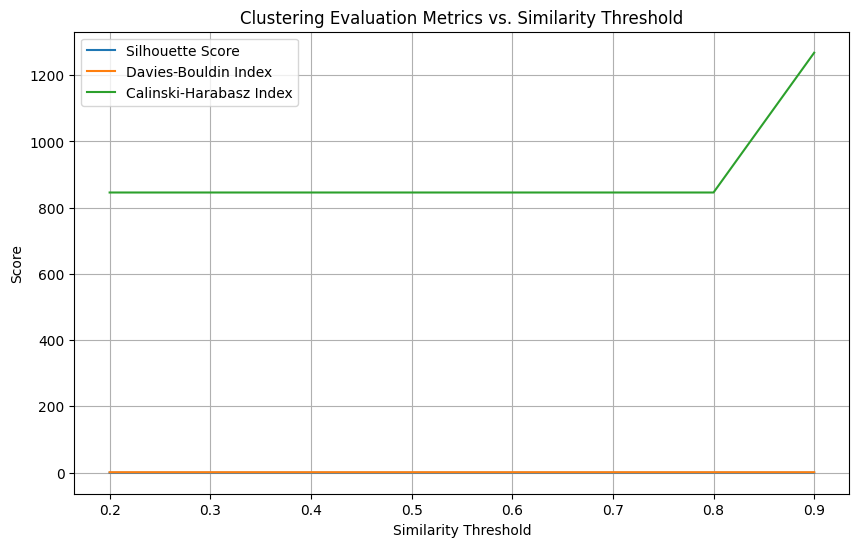

In [ ]:
# Plotting the scores against the threshold values
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, silhouette_scores, label='Silhouette Score')
plt.plot(threshold_values, davies_bouldin_scores, label='Davies-Bouldin Index')
plt.plot(threshold_values, calinski_harabasz_scores, label='Calinski-Harabasz Index')

plt.xlabel('Similarity Threshold')
plt.ylabel('Score')
plt.title('Clustering Evaluation Metrics vs. Similarity Threshold')
plt.legend()
plt.grid(True)
plt.show()